In [1]:
%load_ext autoreload
%autoreload
import os
import sys
import jax
import jax.numpy as jnp
from flax import nnx
import math
    
sys.path.insert(0, os.path.abspath(os.path.join('../')))
from geometric_bayesian.models import MLP
from geometric_bayesian.operators import DenseOperator, SymOperator, PSDOperator, DiagOperator
from geometric_bayesian.densities import Normal, MultivariateNormal
from geometric_bayesian.utils import DataLoader, get_sinusoid_example, contour_plot, ggn, array_to_pytree, pytree_to_array

# sys.path.insert(0, os.path.abspath(os.path.join('/Users/balint/Projects/laplax/')))
sys.path.insert(0, os.path.abspath(os.path.join('/home/bernardo/repos/laplax/')))
from laplax.curv import create_ggn_mv
from laplax.util.loader import input_target_split

### Test PSD Operator

In [2]:
size = 10
rng_key = jax.random.key(0)
sca = jax.random.uniform(rng_key, (1, ))
vec = jax.random.uniform(rng_key, (size, ))
mat = jax.random.uniform(rng_key, (size, size))

In [3]:
mat += mat.transpose() + size*jnp.eye(mat.shape[0])
op = PSDOperator(
    op=mat,
    op_type='raw'
)
op_mv = PSDOperator(
    op=lambda v : jnp.matmul(mat, v),
    op_size=size
)

In [4]:
print("dense")
print(jnp.matmul(mat,vec).tolist())
print("op chol")
print(op(vec).tolist())
print("op mv")
print(op_mv(vec).tolist())

dense
[16.11306381225586, 16.167184829711914, 9.196921348571777, 10.49915599822998, 11.485321998596191, 7.355616569519043, 8.451574325561523, 13.854645729064941, 13.650094032287598, 6.235771179199219]
op chol
[16.11306381225586, 16.167184829711914, 9.196922302246094, 10.49915599822998, 11.485323905944824, 7.355617046356201, 8.451574325561523, 13.854646682739258, 13.650094985961914, 6.235771179199219]
op mv
[16.11306381225586, 16.167184829711914, 9.196921348571777, 10.49915599822998, 11.485321998596191, 7.355616569519043, 8.451574325561523, 13.854645729064941, 13.650094032287598, 6.235771179199219]


In [5]:
print("dense")
print(jnp.linalg.solve(mat, vec).tolist())
print("op chol")
print(op.solve(vec).tolist())
print("op mv")
print(op_mv.solve(vec).tolist())

dense
[0.05774392932653427, 0.06936440616846085, 0.004446753300726414, 0.020178763195872307, 0.030228199437260628, -0.011098397895693779, 0.004241005051881075, 0.03638801723718643, 0.04461517184972763, -0.0036425336729735136]
op chol
[0.05774394050240517, 0.06936440616846085, 0.004446753766387701, 0.020178766921162605, 0.03022819571197033, -0.011098396964371204, 0.004241001792252064, 0.03638801351189613, 0.04461517557501793, -0.0036425332073122263]
op mv
[0.05774390324950218, 0.06936448067426682, 0.004446729552000761, 0.020178765058517456, 0.030228275805711746, -0.011098327115178108, 0.0042411163449287415, 0.03638790547847748, 0.044615115970373154, -0.0036426601000130177]


In [6]:
print("dense")
print(jnp.linalg.eigh(mat)[0].tolist())
print("op chol")
print(op.diagonalize(num_iterations=10, rng_key=rng_key).tolist())
print("op mv")
print(op_mv.diagonalize(num_iterations=10, rng_key=rng_key).tolist())

dense
[7.906601905822754, 8.654257774353027, 9.175858497619629, 9.44333553314209, 9.885660171508789, 10.261805534362793, 10.490107536315918, 11.157332420349121, 12.139627456665039, 20.792448043823242]
op chol
[7.906604766845703, 8.654256820678711, 9.175857543945312, 9.443337440490723, 9.885658264160156, 10.26180648803711, 10.490108489990234, 11.157332420349121, 12.139626502990723, 20.792449951171875]
op mv
[7.906606674194336, 8.654257774353027, 9.175857543945312, 9.443337440490723, 9.885655403137207, 10.26180648803711, 10.490107536315918, 11.157332420349121, 12.139625549316406, 20.792449951171875]


### Test Normal

In [7]:
mean = jnp.array(1.0)
cov = jnp.array(1.0)
pdf = Normal(mean, cov)
x = jnp.linspace(-2, 4, 100)

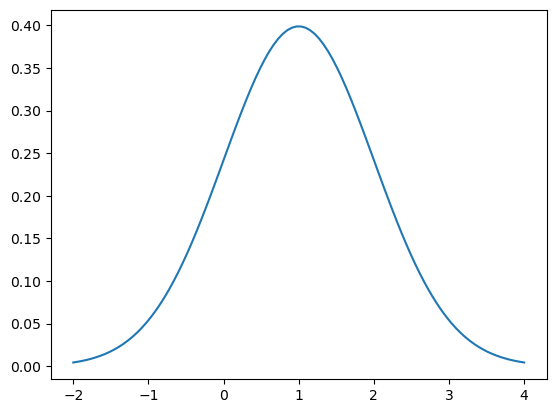

In [8]:
import matplotlib.pyplot as plt
plt.plot(x, pdf(x))

### Test Multivariate Normal

In [9]:
mean = jnp.array([0.0, 0.0])
# cov = jnp.array([1.0, 0.5])
s, u = jnp.diag(jnp.array([1.0, 0.5])), jnp.array([[1.0, 1.0],[-1.0,1.0]])
cov = PSDOperator(
    op=jnp.matmul(u.transpose(), jnp.matmul(s,u)),
    op_type='raw'
)
pdf = MultivariateNormal(mean, cov)

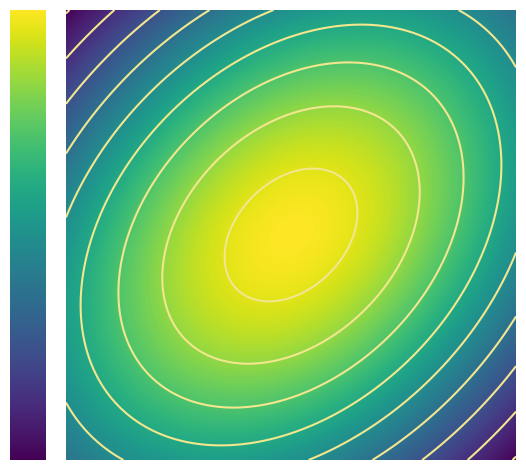

In [10]:
_ = contour_plot(pdf)

### GGN

In [11]:
model = MLP(
    layers=[3, 64, 2],
    rngs=nnx.Rngs(params=0),
    prob_out=False,
)

In [12]:
train_samples = jax.random.uniform(rng_key, (10, model.shape[0]))
train_targets = jax.random.uniform(rng_key, (10, model.shape[1]))

In [13]:
ggn_mv = ggn(
    model=model,
    train_data=(train_samples, train_targets),
    likelihood_density=MultivariateNormal, 
    cov=DiagOperator(jnp.array(1.0), model.shape[1])
)

In [14]:
graph_def, params = nnx.split(model)
num_params = sum(x.size for x in jax.tree.leaves(params))

def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]

In [15]:
ggn_mv_test = create_ggn_mv(
    model_fn,
    params,
    {
        'input': train_samples,
        'target': train_targets
    },
    loss_fn="mse",
    num_curv_samples=train_samples.shape[0],
    num_total_samples=train_samples.shape[0] // 2,
)

In [16]:
ggn_mv(params)

State({
  'layers': {
    0: {
      'bias': VariableState( # 64 (256 B)
        type=Param,
        value=Array([ 0.83594525, -0.5164943 ,  0.03436321, -0.6901761 , -1.0129765 ,
                2.0173502 , -0.32922044,  0.88988614, -0.8655067 ,  0.04127931,
               -0.55534226,  0.31082422,  1.7424173 ,  1.9458586 , -1.3026872 ,
               -0.43174225, -0.7208215 ,  1.0590292 ,  0.5459955 , -0.39184502,
               -1.2446938 ,  0.8741348 ,  1.203608  , -0.33772844,  0.15795769,
                0.2557207 ,  1.0938712 ,  0.4165906 , -0.24840103,  0.10417534,
                0.06286834,  0.01155723, -1.1849875 ,  0.26037198,  2.3539422 ,
                0.3383574 ,  0.13301495, -1.7348628 , -0.71643186,  0.5440027 ,
                0.35448495,  0.87376064, -0.19707194,  2.173308  ,  0.9971882 ,
               -0.8570072 , -1.3360004 ,  0.307318  , -1.6850624 ,  0.5823547 ,
                0.12258087,  0.7222438 , -0.18737113,  0.8183544 ,  0.09960344,
               -0.521

In [17]:
ggn_mv_test(params)

State({
  'layers': {
    0: {
      'bias': VariableState( # 64 (256 B)
        type=Param,
        value=Array([ 0.83594525, -0.5164942 ,  0.03436323, -0.690176  , -1.0129764 ,
                2.0173502 , -0.32922047,  0.88988614, -0.86550665,  0.04127937,
               -0.5553422 ,  0.3108242 ,  1.7424173 ,  1.9458587 , -1.302687  ,
               -0.4317423 , -0.72082144,  1.0590292 ,  0.5459955 , -0.39184502,
               -1.2446938 ,  0.8741347 ,  1.203608  , -0.33772844,  0.15795767,
                0.25572067,  1.0938712 ,  0.41659057, -0.24840105,  0.10417532,
                0.06286832,  0.01155724, -1.1849874 ,  0.26037198,  2.3539422 ,
                0.3383573 ,  0.13301492, -1.7348627 , -0.71643186,  0.5440028 ,
                0.35448498,  0.8737606 , -0.19707195,  2.173308  ,  0.9971881 ,
               -0.8570071 , -1.3360002 ,  0.30731797, -1.6850624 ,  0.5823547 ,
                0.12258084,  0.7222438 , -0.18737113,  0.81835437,  0.09960343,
               -0.521

In [18]:
from laplax.curv.cov import create_posterior_fn, create_full_curvature
from laplax.util.flatten import (
    create_pytree_flattener,
    wrap_factory,
    wrap_function,
)
from laplax.util.mv import diagonal, to_dense
from laplax.util.tree import get_size, eye_like

flatten, unflatten = create_pytree_flattener(params)
mv_wrapped = wrap_function(ggn_mv, input_fn=unflatten, output_fn=flatten)
to_dense(mv_wrapped, layout=get_size(params))

Array([[ 0.22213525, -0.09057042,  0.04878144, ...,  0.08164887,
         0.25214496,  0.26260474],
       [-0.09057043,  0.04564524, -0.01608627, ..., -0.07747104,
        -0.06939048, -0.12981853],
       [ 0.04878145, -0.01608627,  0.02457506, ...,  0.00399241,
         0.1512383 ,  0.00751573],
       ...,
       [ 0.08164886, -0.07747104,  0.00399241, ...,  0.6348059 ,
         0.        ,  0.4586725 ],
       [ 0.252145  , -0.06939048,  0.15123829, ...,  0.        ,
         1.4803627 ,  0.        ],
       [ 0.26260474, -0.12981851,  0.00751573, ...,  0.4586725 ,
         0.        ,  1.4803627 ]], dtype=float32)

In [19]:
num_params = sum(x.size for x in jax.tree.leaves(params))
eye_pytree = array_to_pytree(jnp.eye(num_params), params)
pytree_to_array(jax.lax.map(ggn_mv, eye_pytree, batch_size=None), axis=0)

Array([[ 0.22213525, -0.09057043,  0.04878145, ...,  0.08164886,
         0.252145  ,  0.26260474],
       [-0.09057042,  0.04564524, -0.01608627, ..., -0.07747104,
        -0.06939048, -0.12981851],
       [ 0.04878144, -0.01608627,  0.02457506, ...,  0.00399241,
         0.15123829,  0.00751573],
       ...,
       [ 0.08164887, -0.07747104,  0.00399241, ...,  0.6348059 ,
         0.        ,  0.4586725 ],
       [ 0.25214496, -0.06939048,  0.1512383 , ...,  0.        ,
         1.4803627 ,  0.        ],
       [ 0.26260474, -0.12981853,  0.00751573, ...,  0.4586725 ,
         0.        ,  1.4803627 ]], dtype=float32)

In [108]:
from functools import partial

p = lambda f: MultivariateNormal(f, cov=DiagOperator(1.0, model.shape[1]))

@partial(jax.custom_jvp, nondiff_argnums=(0,1))
def neg_logll(p, y, f):
    return jax.vmap(lambda y, f: -p(f)._logpdf(y), in_axes=(0,0))(y, f).sum()

@partial(jax.custom_jvp, nondiff_argnums=(0,1,3))
@neg_logll.defjvp
def neg_logll_jvp(p, y, primals, tangents):
    f = primals[0]
    v = tangents[0]
    smt = jax.vmap(lambda y, f, v: -p(f)._logpdf_jvp_mean(y, v), in_axes=(0,0,0))(y, f, v)
    return neg_logll(p, y, f), smt.sum(axis=0)

@neg_logll_jvp.defjvp
def neg_logll_hvp(p, y, tangents, primals_new, tangents_new):
    print("p", p)
    print("y", y)
    print("tangents", tangents)
    print("primals_new", primals_new)
    print("tangents_new", tangents_new)
    f = primals_new[0]
    v = tangents_new[0]

    out_1 = neg_logll(p, y, f)
    out_2 = jax.vmap(lambda y, f, v: -p(f)._logpdf_hvp_mean(y, v), in_axes=(0,0,0))(y, f, v).sum(axis=0)

    print("out_1", out_1)
    print("out_2", out_2)
    
    return out_1, out_2

In [98]:
v = jax.random.uniform(rng_key, (10, model.shape[1]))

In [99]:
neg_logll_jvp(p, train_targets, (model(train_samples),), (v,))

(Array(15.245674, dtype=float32), Array(-6.074153, dtype=float32))

In [109]:
jax.jvp(lambda f: neg_logll_jvp(p, train_targets, f, None), (model(train_samples),), (v,) )

p <function <lambda> at 0x7fb20b891a80>
y [[0.947667   0.9785799 ]
 [0.33229148 0.46866846]
 [0.5698887  0.16550303]
 [0.3101946  0.68948054]
 [0.74676657 0.17101455]
 [0.9853538  0.02528262]
 [0.6400418  0.56269085]
 [0.8992138  0.93453753]
 [0.8341402  0.7256162 ]
 [0.5098531  0.02765214]]
tangents None
primals_new (Array([[ 0.03169783,  0.8277545 ],
       [ 0.02892318,  0.55005777],
       [ 0.17845634,  0.38495925],
       [ 0.38646597,  0.4875923 ],
       [-0.06438916,  0.5166038 ],
       [ 0.01629015,  0.73281467],
       [-0.32203412,  0.4488957 ],
       [-0.22535744,  0.70483357],
       [ 0.00535884,  0.47809952],
       [-0.37376425,  0.6492728 ]], dtype=float32),)
tangents_new (Array([[0.947667  , 0.9785799 ],
       [0.33229148, 0.46866846],
       [0.5698887 , 0.16550303],
       [0.3101946 , 0.68948054],
       [0.74676657, 0.17101455],
       [0.9853538 , 0.02528262],
       [0.6400418 , 0.56269085],
       [0.8992138 , 0.93453753],
       [0.8341402 , 0.7256162 ],
 

TypeError: Custom JVP rule must produce primal and tangent outputs with corresponding shapes and dtypes. Expected float32[] (tangent type of float32[]) but got float32[2].

In [36]:
jax.jvp(lambda f: neg_logll(p, train_targets, f), (model(train_samples),), (v,))

(10,)


TypeError: Custom JVP rule must produce primal and tangent outputs with corresponding shapes and dtypes. Expected float32[] (tangent type of float32[]) but got float32[10].

In [37]:
jax.grad(neg_logll,2)(p,train_targets, model(train_samples))

(10,)


TypeError: Custom JVP rule must produce primal and tangent outputs with corresponding shapes and dtypes. Expected float32[] (tangent type of float32[]) but got float32[10].

In [27]:
jax.grad(neg_logll_jvp, 2)(p, train_targets, model(train_samples), None)

TypeError: Custom JVP rule must produce primal and tangent outputs with corresponding shapes and dtypes. Expected float32[] (tangent type of float32[]) but got float32[2].

In [46]:
jax.jacfwd(jax.jacrev(neg_logll,2),2)(p, train_targets, model(train_samples))

(10,)
(10,)


TypeError: Custom JVP rule must produce primal and tangent outputs with corresponding shapes and dtypes. Expected float32[] (tangent type of float32[]) but got float32[10].

In [ ]:
jax.grad(neg_logll, 2)(p, train_targets, model(train_samples))

In [ ]:
v = jax.random.uniform(rng_key, (10,model.shape[1]))
neg_logll_jvp(p, train_targets, (model(train_samples),), (v,))

In [ ]:
neg_logll_hvp(p, train_targets, (model(train_samples),), (v,))

In [ ]:
graph_def, map_params = nnx.split(model)
def model_fn(params):
    return nnx.call((graph_def, params))(train_samples)[0]

def ggn(vec):
    _, jvp = jax.linearize(model_fn, map_params)
    HJv = neg_logll_hvp(p, train_targets, (model_fn(params),), (jvp(vec),))[1]
    return jax.linear_transpose(jvp, vec)(HJv)[0]
    # return HJv

In [ ]:
ggn(map_params)